# Workflow of in-line data process of LDRD20-31 at XPD

## 1. Prepare Queueserver
https://blueskyproject.io/bluesky-queueserver/index.html

https://blueskyproject.io/bluesky-queueserver/re_manager_api.html

### 1.1 Open GUI qserver monitor

In [ ]:
~$ cd ~/Desktop

~$ bash run-queue-monitor.sh

Or

In [ ]:
~$ conda activate 2024-1.0-py310-tiled

~$ queue-monitor --zmq-control-addr tcp://xf28id2-ca2:60615 --zmq-info-addr tcp://xf28id2-ca2:60625

### 1.2 Open a terminal for qserver monitor info

In [ ]:
~$ conda activate 2024-1.0-py310-tiled

~$ qserver-console-monitor --zmq-info-addr=tcp://xf28id2-ca2:60625

## 2. Start pdfstream analysis, save, vis servers
### pdfstream analysis, save, vis servers are running on xf28id2-ca2
### Access to ca2 is limited so make sure thery are running when staff support is available

# 3. Activate an conda environment for LDRD kafka

In [ ]:
~$ conda activate 2024-1.0-py310-tiled-blop

~$ python kafka_consumer_iterate_RM.py xpd xpd-ldrd20-31

### blop (package for ML agent), diffpy.pdffit2, diffpy.pdfgetx, ...etc are running in LDRD kafka
### make sure the following packages/version could work.

In [ ]:
import pymatgen as pm
from diffpy.pdffit2 import PdfFit
from diffpy.Structure import loadStructure
from pyobjcryst import loadCrystal
from diffpy.pdfgetx import PDFConfig  ## .__ver__() >= 2.2.1
from tiled.client import from_uri, from_profile

### Things to do in LDRD kafka:

### Before printing message

#### I. Load queue tasks into qserver from reading inputs_**.xlsx

In [ ]:
## Input varaibales: read from inputs_qserver_kafka.xlsx
xlsx = '/home/xf28id2/Documents/ChengHung/inputs_qserver_kafka_ML.xlsx'
input_dic = de._read_input_xlsx(xlsx, sheet_name='inputs')

#### II. Decide if some works were executed

In [ ]:
use_good_bad = True
post_dilute = True
write_agent_data = True
USE_AGENT_iterate = False
iq_to_gr = True  
search_and_match = True
fitting_pdf = False
use_sandbox = True

#

### Data Model of BlueSky

https://blueskyproject.io/event-model/main/user/explanations/data-model.html#data-model

(-0.5, 863.5, 1271.5, -0.5)

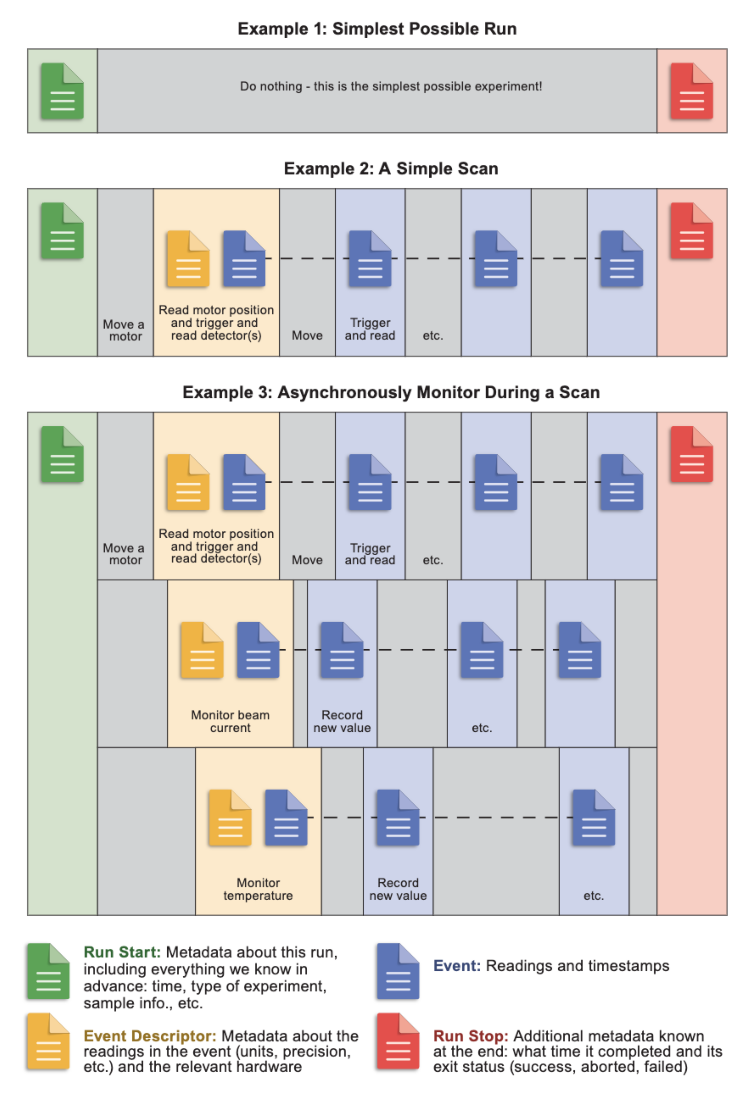

In [1]:
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
# %matplotlib widget

plt.close('all')
cwd = os.getcwd()
png = cwd + '/document-generation-timeline.png'
image = imageio.imread(png)
plt.figure(figsize=(12,14))
plt.imshow(image)
plt.axis('off')

#

####################### Needs to know about the subscribed documents(doc) ##################################

by 2024/05/28 - 06/02 commissioning:

The data acquisition plans that will be executed by qserver are:

##### 1. take_a_uvvis_csv_q() --> stream name: take_a_uvvis

##### 2. xray_uvvis_plan()    --> stream name: absorbance, fluorescence, scattering

#####

The scattering data will be processed by analysis server and sent to sandbox Tiled.

#### The subscription to sandbox Tiled will also generate the documents as shown above.

#### Thus, while printing message for "Start", "Event", and "Stop" additional conditions are added.

## The idea is to grab reduced I(Q) from sandbox Tiled vs. UV-Vis from raw data Tiled.

#### To be more easily distinguish the documents from raw vs.from sandbox, a key "topic" is added in sandbox documents.

####################### Needs to know about the subscribed documents(doc) ##################################

#

### Things to do in LDRD kafka:

### After printing message

#### I. Printing metadta in 'start' of sandbox doc

In [ ]:
if name == 'start' and ('topic' in doc[1]):
    print(
        f"\n\n\n{datetime.datetime.now().isoformat()} documents {name}\n"
        f"document keys: {list(message.keys())}")
    # time.sleep(5)
    ...

#### II. Printing 'event' of sandbox doc to get metadata and reduced I(Q)

In [ ]:
if (name == 'event') and ('topic' in doc[1]):
    ...
    global entry, iq_Q, iq_I
    iq_I_uid  = doc[1]['data']['chi_I']
    entry = sandbox_tiled_client[iq_I_uid]
    df = entry.read()
    # print(f'{entry.metadata = }')
    iq_Q = df['chi_Q'].to_numpy()
    iq_I = df['chi_I'].to_numpy()

#### III. Printing 'stop' to get raw data uid and stream names

There will three scenarios while printing 'stop'

#### 1. Acquisition of xray_uvvis_plan finished but analysis of pdfstream not yet
#####  Not assign uid, stream_list

In [ ]:
if (name == 'stop') and ('scattering' in message['num_events']):
    print('\n*** qsever stop for data export, identification, and fitting ***\n')
    print(f"\n\n\n{datetime.datetime.now().isoformat()} documents {name}\n"
          f"contents: {pprint.pformat(message)}"
    )
    ...
    time.sleep(1)   

#### 2. With taking xray_uvvis_pla, analysis of pdfstream finished
##### Obtain raw data uid by reading metadata in sandbox Tiled

In [ ]:
elif (name == 'stop') and ('topic' in doc[1]) and (len(message['num_events'])>0):
    print(f"\n\n\n{datetime.datetime.now().isoformat()} documents {name}\n"
          f"contents: {pprint.pformat(message)}"
    )
    ## wait 1 second for databroker to save data
    time.sleep(1)
    uid = entry.metadata['run_start']
    stream_list = tiled_client[uid].metadata['summary']['stream_names']

#### 3. Only take a Uv-Vis, no X-ray data but still do analysis of pdfstream
##### Stop queue first for appending another take_a_uvvis
##### Obtain raw data uid in bluesky doc, message for access to Uv-Vis data  

In [ ]:
elif (name == 'stop') and ('take_a_uvvis' in message['num_events']):
    print('\n*** qsever stop for data export, identification, and fitting ***\n')

    print(f"\n\n\n{datetime.datetime.now().isoformat()} documents {name}\n"
          f"contents: {pprint.pformat(message)}"
    )

    inst1 = BInst("queue_stop")
    RM.item_add(inst1, pos='front')
    ## wait 1 second for databroker to save data
    time.sleep(1)
    uid = message['run_start']
    stream_list = list(message['num_events'].keys())

#### IV. When uid is assigned and type is a string, move to data fitting, calculation

In [ ]:
if (name == 'stop') and (type(uid) is str):
    print(f'\n**** start to export uid: {uid} ****\n')
    print(f'\n**** with stream name in {stream_list} ****\n')
    ...

#### IV.I. Process scattering data

In [ ]:
    if 'scattering' in stream_list:
        ...
        if use_sandbox:
            ....
        if iq_to_gr:
            ...
        if search_and_match:
            ...
        if fitting_pdf:
            ...
        ## remove 'scattering' from stream_list to avoid redundant work in next for loop
        stream_list.remove('scattering')

#### IV.II. Process Uv-Vis data

In [ ]:
    ## Export, plotting, fitting, calculate # of good/bad data, add queue item
    for stream_name in stream_list:
        ## Read data from databroker and turn into dic
        qepro_dic, metadata_dic = de.read_qepro_by_stream(
            uid, stream_name=stream_name, data_agent='tiled', beamline_acronym=beamline_acronym_01)
        ...
        de.dic_to_csv_for_stream(saving_path, qepro_dic, metadata_dic, stream_name=stream_name)
        print(f'\n** export {stream_name} in uid: {uid[0:8]} to ../{os.path.basename(saving_path)} **\n')
        ## Plot data in dic
        u = plot_uvvis(qepro_dic, metadata_dic)
        ...
        u.plot_data(clear_fig=clear_fig)
        print(f'\n** Plot {stream_name} in uid: {uid[0:8]} complete **\n')

In [ ]:
        ## Idenfify good/bad data if it is a fluorescence scan in 'take_a_uvvis'
        if qepro_dic['QEPro_spectrum_type'][0]==2 and stream_name=='take_a_uvvis':
            ...

In [ ]:
        ## Apply an offset to zero baseline of absorption spectra
        elif stream_name == 'absorbance':
            ...

In [ ]:
        ## Avergae scans in 'fluorescence' and idenfify good/bad
        elif stream_name == 'fluorescence':
            ...

In [ ]:
        ## Skip peak fitting if qepro type is absorbance
        if qepro_dic['QEPro_spectrum_type'][0] == 3:  
            print(f"\n*** No need to carry out fitting for {stream_name} in uid: {uid[:8]} ***\n")

In [ ]:
        else: 
            ## for a good data, type(peak) will be a np.array and type(prop) will be a dic
            ## fit the good data, export/plotting fitting results
            ## append data_id into good_data or bad_data for calculate numbers
            if (type(peak) is np.ndarray) and (type(prop) is dict):
                x, y, p, f_fit, popt = da._fitting_in_kafka(x0, y0, data_id, peak, prop, dummy_test=dummy_test) 

In [ ]:
                ## Calculate PLQY for fluorescence stream
                if (stream_name == 'fluorescence') and (PLQY[0]==1):
                    ...

In [ ]:
                    ## Save data for ML agent
                    ## TODO: add phase ratio & particle size from scattering
                    if write_agent_data:
                        ...
                    if USE_AGENT_iterate:
                        ...

In [ ]:
            ## Save fitting data
            ...
            de.dic_to_csv_for_stream(saving_path, qepro_dic, metadata_dic, stream_name=stream_name, fitting=ff, plqy_dic=plqy_dic)
            ...

            ## Plot fitting data
            u.plot_peak_fit(x, y, f_fit, popt, peak=p, fill_between=True)
            ...

In [ ]:
            ## Append good/bad idetified results
            if stream_name == 'take_a_uvvis':
                good_data.append(data_id)

In [ ]:
        ...    
        print('########### Events printing division ############\n')
        ...

In [ ]:
        ## Depend on # of good/bad data, add items into queue item or stop 
        if stream_name == 'take_a_uvvis' and use_good_bad:
            ...

In [ ]:
        ## Add predicted new points from ML agent into qserver    
        elif stream_name == 'fluorescence' and USE_AGENT_iterate and agent_iteration[-1]:
            ...